# Creación MasterTable

In [6]:
import numpy as np
import astropy.units as u
from astropy.table import Table, QTable, join,vstack
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt


from astroquery.simbad import Simbad
from astropy.coordinates import Angle

from  astroquery.gaia import Gaia
import pandas as pd

1- Apertura tablas cruzadas

In [21]:
laura = Table.read('../CatalogosRadio/laura.csv') #Leer tabla
laura=laura.to_pandas()
laura=laura.rename(columns={'Objeto':'Name'})      
laura=Table.from_pandas(laura)

CM_L_S = Table.read('../CatalogosRadio/CM_L_S',format='ascii.ecsv') #Leer tabla
CM_L_B= Table.read('../CatalogosRadio/CM_L_B', format='ascii.ecsv') #Leer tabla
CM_L_B3 = Table.read('../CatalogosRadio/CM_L_B3', format='ascii.ecsv') #Leer 
CM_L_N= Table.read('../CatalogosRadio/CM_L_N', format='ascii.ecsv') #Leer tabla

2-MasterTable a partir de la función join

In [22]:
def join_two_tables (tab1,tab2,keys,join_type):
    joined = join(tab1,tab2,keys,join_type)
    
    return joined

Se crea una "MasterTable" de izquierda a derecha que contenga todos los LINERS e incluya la información que hay en los diferentes catálogos para ellos.

In [36]:
MergerLS= join_two_tables(laura, CM_L_S['Name','Beam','BPA','Speak','RMS'], keys="Name", join_type='left')
MergerLSB = join_two_tables(MergerLS, CM_L_B['Name','Beam','Q', 'PA'], keys='Name', join_type='left')
MergerLSBB3 = join_two_tables(MergerLSB, CM_L_B3['Name', 'det', 'morph','log(Lcore)', 'log(Ltotal)','logMBH','log[OIII]','logEddRatio'], keys='Name', join_type='left')
Finaltable = join_two_tables(MergerLSBB3, CM_L_N['Name','AType','Lp15GHz','Dist','St15GHz'], keys='Name', join_type='left')

Finaltable


Name,RA,DEC,Redshift,Magnitud (V),Beam_1,BPA,Speak,RMS,Beam_2,Q,PA,det,morph,log(Lcore),log(Ltotal),logMBH,log[OIII],logEddRatio,AType,Lp15GHz,Dist,St15GHz
,,,,,,,,,,,,,,,,,,,,W / Hz,Mpc,mJy
str7,str12,str12,str6,str5,str9,float64,str10,float64,str9,str2,float64,str5,str1,str6,str5,str8,str6,str6,str9,float32,float32,float32
IC1459,22 57 10.60,−36 27 44.0,"0,0055","10,54",--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
NGC1052,02 41 04.80,+08 15 20.8,"0,0049","11,04",--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
NGC2639,08 43 38.08,+50 12 20.0,"0,0111","11,76",--,--,--,--,0.20x0.19,++,68.0,I,C,37.61,38.50,7.94,39.60,-2.93,--,--,--,--
NGC2655,08 55 37.73,+78 13 23.1,"0,0047","10,39",--,--,--,--,0.20x0.20,+,0.0,I,E,37.59,37.97,7.74,39.44,-2.89,--,--,--,--
NGC266,00 49 47.80,+32 16 39.8,"0,0155","11,82",--,--,--,--,0.48x0.31,+,-40.0,I,A,36.94,37.02,8.37,39.43,-3.53,L1.9,21.28,62.4,4.1
NGC2681,08 53 32.73,+51 18 49.3,"0,0023","10,86",0.17x0.14,-87.2,0.34+-0.01,9.6,0.19x0.16,++,51.8,I,C,35.51,35.99,7.07,38.37,-3.29,L1.9,19.48,13.3,1.4
NGC2685,08 55 34.71,+58 44 03.83,"0,003","11,35",--,--,--,--,--,--,--,U,-,<34.82,-,6.59^{*},38.41,-2.73,S2/T2:,19.45,16.2,0.9
NGC2787,09 19 18.56,+69 12 12.0,"0,0023","11,25",--,--,--,--,--,--,--,I,A,36.28,36.41,7.61^{*},38.37,-3.79,L1.9,20.15,13.0,7.0


Se guarda la tabla

In [105]:
Finaltable.write('../CatalogosRadio/Master_table.csv', overwrite=True) 

La pasamos a pandas por si fuera mejor para tratar datos.

In [43]:
Finaltable.to_pandas()

,Name,RA,DEC,Redshift,Magnitud (V),Beam_1,BPA,Speak,RMS,Beam_2,...,morph,log(Lcore),log(Ltotal),logMBH,log[OIII],logEddRatio,AType,Lp15GHz,Dist,St15GHz
0,IC1459,22 57 10.60,−36 27 44.0,"0,0055","10,54",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NGC1052,02 41 04.80,+08 15 20.8,"0,0049","11,04",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NGC2639,08 43 38.08,+50 12 20.0,"0,0111","11,76",NaN,NaN,NaN,NaN,0.20x0.19,...,C,37.61,38.50,7.94,39.60,-2.93,NaN,NaN,NaN,NaN
3,NGC2655,08 55 37.73,+78 13 23.1,"0,0047","10,39",NaN,NaN,NaN,NaN,0.20x0.20,...,E,37.59,37.97,7.74,39.44,-2.89,NaN,NaN,NaN,NaN
4,NGC266,00 49 47.80,+32 16 39.8,"0,0155","11,82",NaN,NaN,NaN,NaN,0.48x0.31,...,A,36.94,37.02,8.37,39.43,-3.53,L1.9,21.280001,62.400002,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,NGC7331,22 37 04.09,+34 24 56.3,"0,0038","9,41",NaN,NaN,NaN,NaN,0.15x0.15,...,-,<34.95,-,8.02^{*},38.30,-3.76,T2,19.430000,14.300000,1.1
71,NGC7743,23 44 21.14,+09 56 02.7,"0,0057","12,43",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NGC833,02 09 20.88,-10 07 59,"0,0129","12,9",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NGC835,02 09 24.69,-10 08 10.,"0,0136","12,41",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


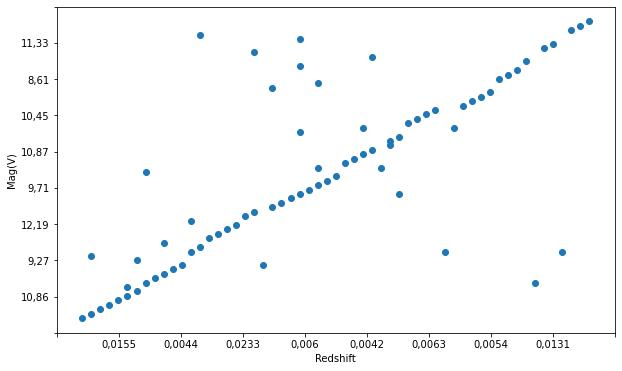

In [99]:
fig,ax = plt.subplots(figsize=(10,6))

ax.scatter(Finaltable['Redshift'],Finaltable['Magnitud (V)'])
ax.set_xlabel('Redshift')
xmin,xmax= ax.get_xlim()

ax.set_xticks(np.linspace(xmin,xmax,10))
ax.set_ylabel('Mag(V)')
ymin,ymax= ax.get_ylim()
ax.set_yticks(np.linspace(ymin,ymax,10))


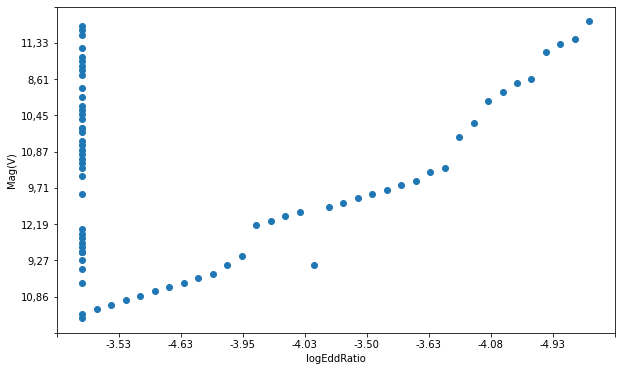

In [98]:
fig,ax = plt.subplots(figsize=(10,6))

ax.scatter(Finaltable['logEddRatio'],Finaltable['Magnitud (V)'])
ax.set_xlabel('logEddRatio')
xmin,xmax= ax.get_xlim()
ax.set_xticks(np.linspace(xmin,xmax,10))
ax.set_ylabel('Mag(V)')
ymin,ymax= ax.get_ylim()
ax.set_yticks(np.linspace(ymin,ymax,10))

In [ ]:
col1 = 'logE'


fig, ax = plt.subplots(ncols=2, figsize=(14,6))   # This plot will have two panels in a single horizontal row.

for axi, col in zip(ax, cols):
    axi.hist(data1[col],    bins=np.arange(0, 7, 0.05), label='Full sample')  # This plots the blue histogram
    axi.hist(cluster1[col], bins=np.arange(0, 7, 0.05), label='Cluster')      # This plots the orange histogram
    axi.legend()
    
    description = data1[col].description
    unit = data1[col].unit

    axi.set_xlabel(f"{description} [{unit}]")
    axi.set_ylabel('Number of stars')